In [0]:
import requests
import pandas as pd
import math

import json

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
# Features
feature_cols = [
    "temperature_2m", "precipitation", "wind_speed_10m",
    "wind_speed_80m", "wind_speed_120m", "wind_speed_180m",
    "cloud_cover"
]

In [0]:
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    # Lisbon coordinates
	"latitude": 38.716885,
	"longitude": -9.140233,
	# 1 Year Historical data
	"start_date": "2024-05-01",
	"end_date": "2025-05-01",
	"hourly": feature_cols
}

response = requests.get(url, params=params)
data = response.json()
df = pd.DataFrame(data['hourly'])

In [0]:
df

,time,temperature_2m,precipitation,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,cloud_cover
0,2024-05-01T00:00,14.0,0.0,8.7,20.1,23.2,26.9,96
1,2024-05-01T01:00,13.4,0.0,11.9,26.3,29.1,31.1,73
2,2024-05-01T02:00,12.4,0.0,8.6,19.8,22.8,26.4,47
3,2024-05-01T03:00,12.2,0.0,7.4,22.3,26.6,29.4,39
4,2024-05-01T04:00,11.5,0.0,6.6,17.8,21.3,26.6,38
...,...,...,...,...,...,...,...,...
8779,2025-05-01T19:00,18.8,0.0,5.1,8.0,8.4,10.0,100
8780,2025-05-01T20:00,17.6,0.1,5.2,11.2,13.4,15.6,100
8781,2025-05-01T21:00,17.3,0.0,1.3,3.9,6.6,11.3,100
8782,2025-05-01T22:00,16.6,0.0,1.8,0.7,3.9,9.3,100


## Transform data to spark df

In [0]:
sdf = spark.createDataFrame(df)
# Todo: preprocessing

# Save data to local file
# sdf.write.format("delta").mode("overwrite").save("/tmp/weather_historical_clean")

## Basic threshold model

In [0]:
# Threshold list builder
lower_q = 0.015
upper_q = 0.985

threshold_data = []

for feature in feature_cols:
    q_low, q_high = sdf.approxQuantile(feature, [lower_q, upper_q], 0.01)
    threshold_data.append((feature, float(q_low), float(q_high)))

schema = StructType([
    StructField("feature", StringType(), False),
    StructField("lower_threshold", DoubleType(), False),
    StructField("upper_threshold", DoubleType(), False)
])

threshold_sdf = spark.createDataFrame(threshold_data, schema)
# Save threshold list
# threshold_df.write.format("delta").mode("overwrite").save("/tmp/quantile_threshold_model")

display(threshold_sdf)


### Apply basic threshold model to training historical dataset

In [0]:
sdf_flagged = sdf

for row in threshold_data:
    feature, low, high = row
    sdf_flagged = sdf_flagged.withColumn(
        f"{feature}_anomaly",
        when((col(feature) < lit(low)) | (col(feature) > lit(high)), 1).otherwise(0)
    )

In [0]:
pandas_df = sdf_flagged.toPandas()

In [0]:
pandas_df[pandas_df["temperature_2m_anomaly"] != 0]
# pandas_df[pandas_df["temperature_2m"] >32.6]
# pandas_df["temperature_2m"].max()

#### Visualisação

In [0]:
# Convert to pandas (for small data only)
pdf = df_flagged.select("time", "temperature_2m", "temperature_2m_anomaly").orderBy("time").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Full line (black)
plt.plot(pdf["time"], pdf["temperature_2m"], color="black", label="Temperature")

# Overlay anomalies (red)
anomalies = pdf[pdf["temperature_2m_anomaly"] == 1]
plt.plot(anomalies["time"], anomalies["temperature_2m"], 'ro', label="Anomalies")

# Horizontal anomaly threshold line
# plt.axhline(y=upper_threshold, color='red', linestyle='--', label='Upper threshold')
# plt.axhline(y=lower_threshold, color='blue', linestyle='--', label='Lower threshold')

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Over Time with Anomalies Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## KMeans outlier detection model

### Utility functions

In [0]:
def train_kmeans_model(df, k, features_col):
    # Trains a k-means model.
    # Inspired by https://spark.apache.org/docs/latest/ml-clustering.html
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setFeaturesCol(features_col) # Set custom feature vector col
    model = kmeans.fit(df)
    return model

def compute_distance(point, cluster_id):
    # Function to compute distance between a point and its cluster centroid - "centers" needs to be callable
    center = centers[cluster_id]
    return float(math.sqrt(sum((p - c)**2 for p, c in zip(point, center))))

### Assembly of dataset and preprocessing

In [0]:
# Combine different feature columns into one single column (adds a "features" column of type vector)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_sdf = assembler.transform(sdf)

# Define scaler
scaler = StandardScaler(
    inputCol="features", # assembled vector
    outputCol="features_scaled", # standardized vector
    withMean=True, # mean 0
    withStd=True # std dev 1
)

scaler_model = scaler.fit(assembled_sdf)
scaled_sdf = scaler_model.transform(assembled_sdf)

# Save scaler model for usage in streaming
scaler_model.write().overwrite().save("/dbfs/tmp/scaler_model")

scaled_sdf.select("features", "features_scaled").show(truncate=False) # Check

+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|features                           |features_scaled                                                                                                                                  |
+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|[14.0,0.0,8.7,20.1,23.2,26.9,96.0] |[-0.6590445687508486,-0.19775002273369255,-0.10560424671887478,0.180274562944951,0.16579368256782015,0.20510626564808207,1.087019313747202]      |
|[13.4,0.0,11.9,26.3,29.1,31.1,73.0]|[-0.7750025477703008,-0.19775002273369255,0.5002305289146354,0.8329430943676615,0.7169921349709903,0.5525325483524708,0.49537596572697845]       |
|[12.4,0.0,8.6,19.8,22.8,26.4,47.0] |[-0.9682658461360546,-0.19775002273369255,-

In [0]:
# observe: we have a new "features" column
scaled_sdf

Out[23]: DataFrame[time: string, temperature_2m: double, precipitation: double, wind_speed_10m: double, wind_speed_80m: double, wind_speed_120m: double, wind_speed_180m: double, cloud_cover: bigint, features: vector, features_scaled: vector]

### K-Means Cluster Count - Discovery/Tuning

In [0]:
# Loop to test different k values and evaluate the models
for k in range(2, 10):
    # Train k means with specific k
    model = train_kmeans_model(scaled_sdf, k, "features_scaled")

    # Make predictions
    predictions = model.transform(scaled_sdf)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette score:" + str(silhouette) + " for k = " + str(k))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers (scaled): ")
    for center in centers:
        print(center)

    print("---")

### Optimal Model & Application on Historical Data


In [0]:
# save best model with k=4 for streaming usage
model = train_kmeans_model(scaled_sdf, 4, "features_scaled")
predicted_sdf = model.transform(scaled_sdf)
model.write().overwrite().save("/dbfs/tmp/kmeans_model")

In [0]:
# Cluster centers
centers = model.clusterCenters()
print(centers)

# UDF (user defined function) for distance computation
distance_udf = udf(compute_distance, DoubleType()) # with double as return value for distance
scored_sdf = predicted_sdf.withColumn(
    "distance_cluster_center", 
    distance_udf(col("features_scaled"), col("prediction"))
) # apply distance udf to all points

# Compute distance threshold for anomalies
distance_threshold = scored_sdf.approxQuantile("distance_cluster_center", [0.95], 0.01)[0] # 0.95 percentile as threshold

# Save threshold as a JSON file
with open("./distance_threshold.json", "w") as f:
    json.dump({"distance_threshold": distance_threshold}, f)

# Flag highest distances as anomalies
scored_sdf = scored_sdf.withColumn(
    "is_anomaly",
    when(col("distance_cluster_center") > distance_threshold, 1).otherwise(0)
)

[array([-0.0497898 , -0.19595067, -0.72959666, -0.73886278, -0.69871916,
       -0.6038436 , -1.04373645]), array([-0.36048278,  1.30037522,  1.82939816,  2.07630869,  2.12046792,
        2.08727094,  0.74657274]), array([-0.26981792, -0.05198933, -0.60829716, -0.59830901, -0.56564265,
       -0.53206522,  0.82759753]), array([ 0.38698738, -0.15859691,  0.61027988,  0.54117061,  0.46937153,
        0.37773527, -0.22029292])]


In [0]:
scored_sdf.select("features", "features_scaled", "prediction", "distance_cluster_center", "is_anomaly").show(truncate=False) # Check

+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------+----------+
|features                           |features_scaled                                                                                                                                  |prediction|distance_cluster_center|is_anomaly|
+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------+----------+
|[14.0,0.0,8.7,20.1,23.2,26.9,96.0] |[-0.6590445687508486,-0.19775002273369255,-0.10560424671887478,0.180274562944951,0.16579368256782015,0.20510626564808207,1.087019313747202]      |2         |1.4755868928218505     |0         |
|[13.4,0.0,11.9,26.3,29.1,31.1,73.0]|[-0.7750025477703008,-0.19775002273369255,0

### Large year round visualization

In [0]:
# Selection of relevant columns and conversion to pandas for visualization
plot_df = scored_sdf.select(
    "time",
    "temperature_2m",
    "wind_speed_10m",
    "distance_cluster_center",
    "is_anomaly"
).orderBy("time").toPandas()

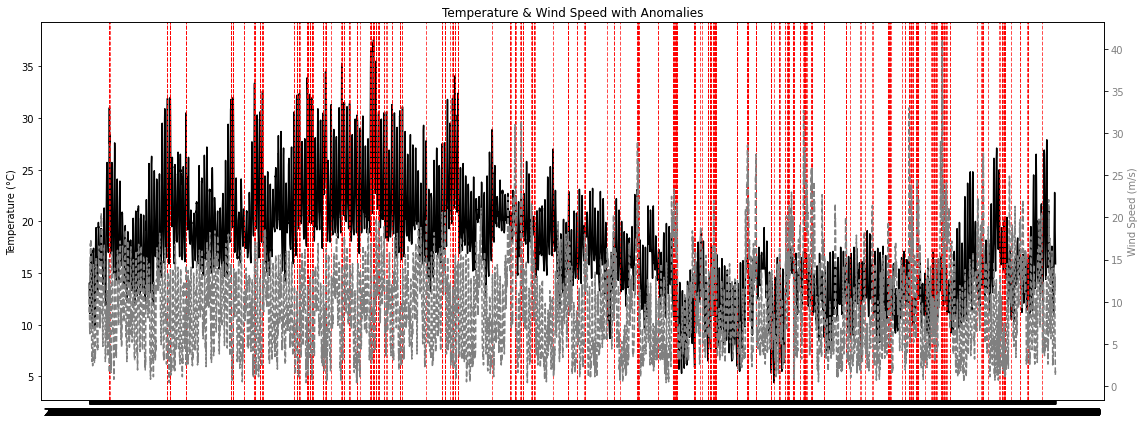

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Secondary axis for wind speed
ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df["wind_speed_10m"], color="gray", linestyle='--', label="Wind Speed (10m)")
ax2.set_ylabel("Wind Speed (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# Title and legend
plt.title("Temperature & Wind Speed with Anomalies")
fig.tight_layout()
plt.show()